In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
import seaborn as sns

## data shrinkage

In [3]:
file_path = 'C:/Users/junya/Desktop/Data Science for Business/final project/train_data.csv'
chunk_size = 1000000  # 1 million rows of data as a chunk for faster read-in

data = [] # palce holder for new data

# read-in by chunks and take 1% of each chunk randomly as part of the new training dataset
for chunk in pd.read_csv(file_path, sep = '|', chunksize=chunk_size):
    sampled_chunk = chunk.sample(frac=0.01, random_state=42)
    data.append(sampled_chunk)

# concat all the subsets
shrinked_dataset = pd.concat(data)

In [16]:
# check shape
shrinked_dataset.shape

,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,...,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d
987231,0,1425703,3744,2227,3,142,36,5,17,80,...,8,4,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,11,42,1
79954,0,1955614,5858,2841,7,175,37,4,12,34,...,17,2,-1,-1,-1,2,15^16^17^18^19^20^21^22^23,6,17,1
567130,0,1965005,1184,2410,3,142,36,5,16,80,...,4,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,9,42,1
500891,0,1668419,2336,4517,6,139,60,3,14,78,...,8,4,16,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,38,1
55399,0,2232149,1669,4362,7,207,17,5,17,13,...,14,5,18,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,11,17,1


In [18]:
# chech if there's any NA in the dataset
na_status = shrinked_dataset.isna().any()
na_status

label                          False
uid                            False
task_id                        False
adv_id                         False
creat_type_cd                  False
adv_prim_id                    False
dev_id                         False
inter_type_cd                  False
slot_id                        False
spread_app_id                  False
tags                           False
app_first_class                False
app_second_class               False
age                            False
city                           False
city_rank                      False
device_name                    False
device_size                    False
career                         False
gender                         False
net_type                       False
residence                      False
his_app_size                   False
his_on_shelf_time              False
app_score                      False
emui_dev                       False
list_time                      False
d

In [20]:
shrinked_dataset.to_csv('shrinked_data.csv', index=False)

## Data preprocessing

In [22]:
df = pd.read_csv('shrinked_data.csv')

In [24]:
# train & test data (unstandardized) split
# use stratified sampling to make sure the proportion of click and non-click response in each set is the same
# split into 10 fold for later cross validation
X = df.drop(columns=['label'])  # characters
y = df['label']  # label

# 10-fold cross validation
skf = StratifiedKFold(n_splits=10)

# place holder for splitted datasets
df_list = []

# split data into 10 fold and generate 10 sets of training data and testing data
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_data = df.iloc[train_index]  # train data
    test_data = df.iloc[test_index]    # test data
    df_list.append((train_data, test_data))

In [36]:
# example of how to refere to each set of training and testing data
# index range is [0,9]
train_data, test_data = df_list[0]

In [49]:
# standardization of data to prepare it for regressions
# Creating a copy
std_df = df.copy()

# No need to standardize response variable
exclude_column = 'label'

# Identifying columns to standardize
columns_to_standardize = [col for col in df.columns if (col != 'label' and col != 'communication_onlinerate')]

# Applying standardization to the selected columns
scaler = StandardScaler()
std_df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [55]:
# standardized dataset split
# use std_df for later model training
std_X = std_df.drop(columns=['label'])
std_y = std_df['label']
skf = StratifiedKFold(n_splits=10)
std_df_list = []
for std_fold_idx, (std_train_index, std_test_index) in enumerate(skf.split(std_X, std_y)):
    std_train_data = std_df.iloc[std_train_index]  # train data
    std_test_data = std_df.iloc[std_test_index]    # test data
    std_df_list.append((std_train_data, std_test_data))

## Exploratory Data Analysis
#### conducted on unstandardized df

<Axes: >

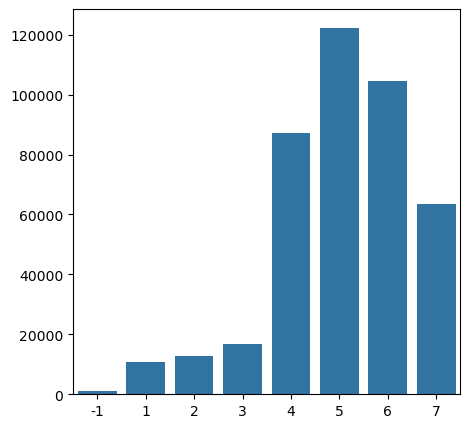

In [87]:
# age distribution
age = Counter(age for age in df['age'])
items = sorted(age.items())
x_age_count = [i[0] for i in items]
y_age_count = [i[1] for i in items]
plt.figure(figsize = (5, 5))
sns.barplot(y = y_age_count, x = x_age_count)

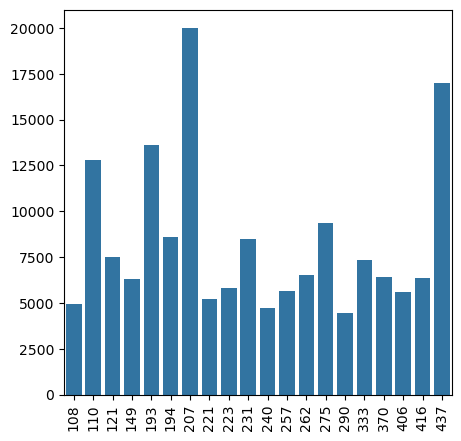

In [85]:
city = Counter(city for city in df['city'])
city_items = city.most_common(20)
x_city_count = [i[0] for i in city_items]
y_city_count = [i[1] for i in city_items]
plt.figure(figsize = (5, 5))
sns.barplot(y = y_city_count, x = x_city_count)
plt.xticks(rotation=90)
plt.show()

<Axes: >

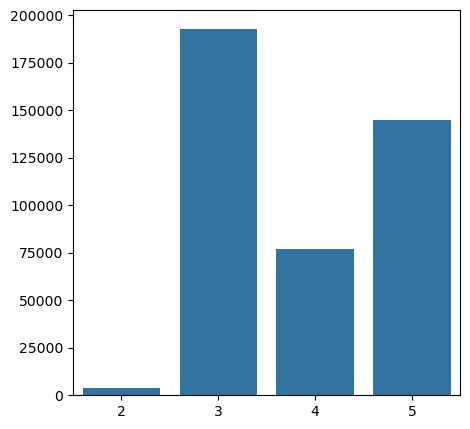

In [89]:
city_rank = Counter(city_rank for city_rank in df['city_rank'])
city_rank_items = sorted(city_rank.items())
x_city_rank_count = [i[0] for i in city_rank_items]
y_city_rank_count = [i[1] for i in city_rank_items]
plt.figure(figsize = (5, 5))
sns.barplot(y = y_city_rank_count, x = x_city_rank_count)

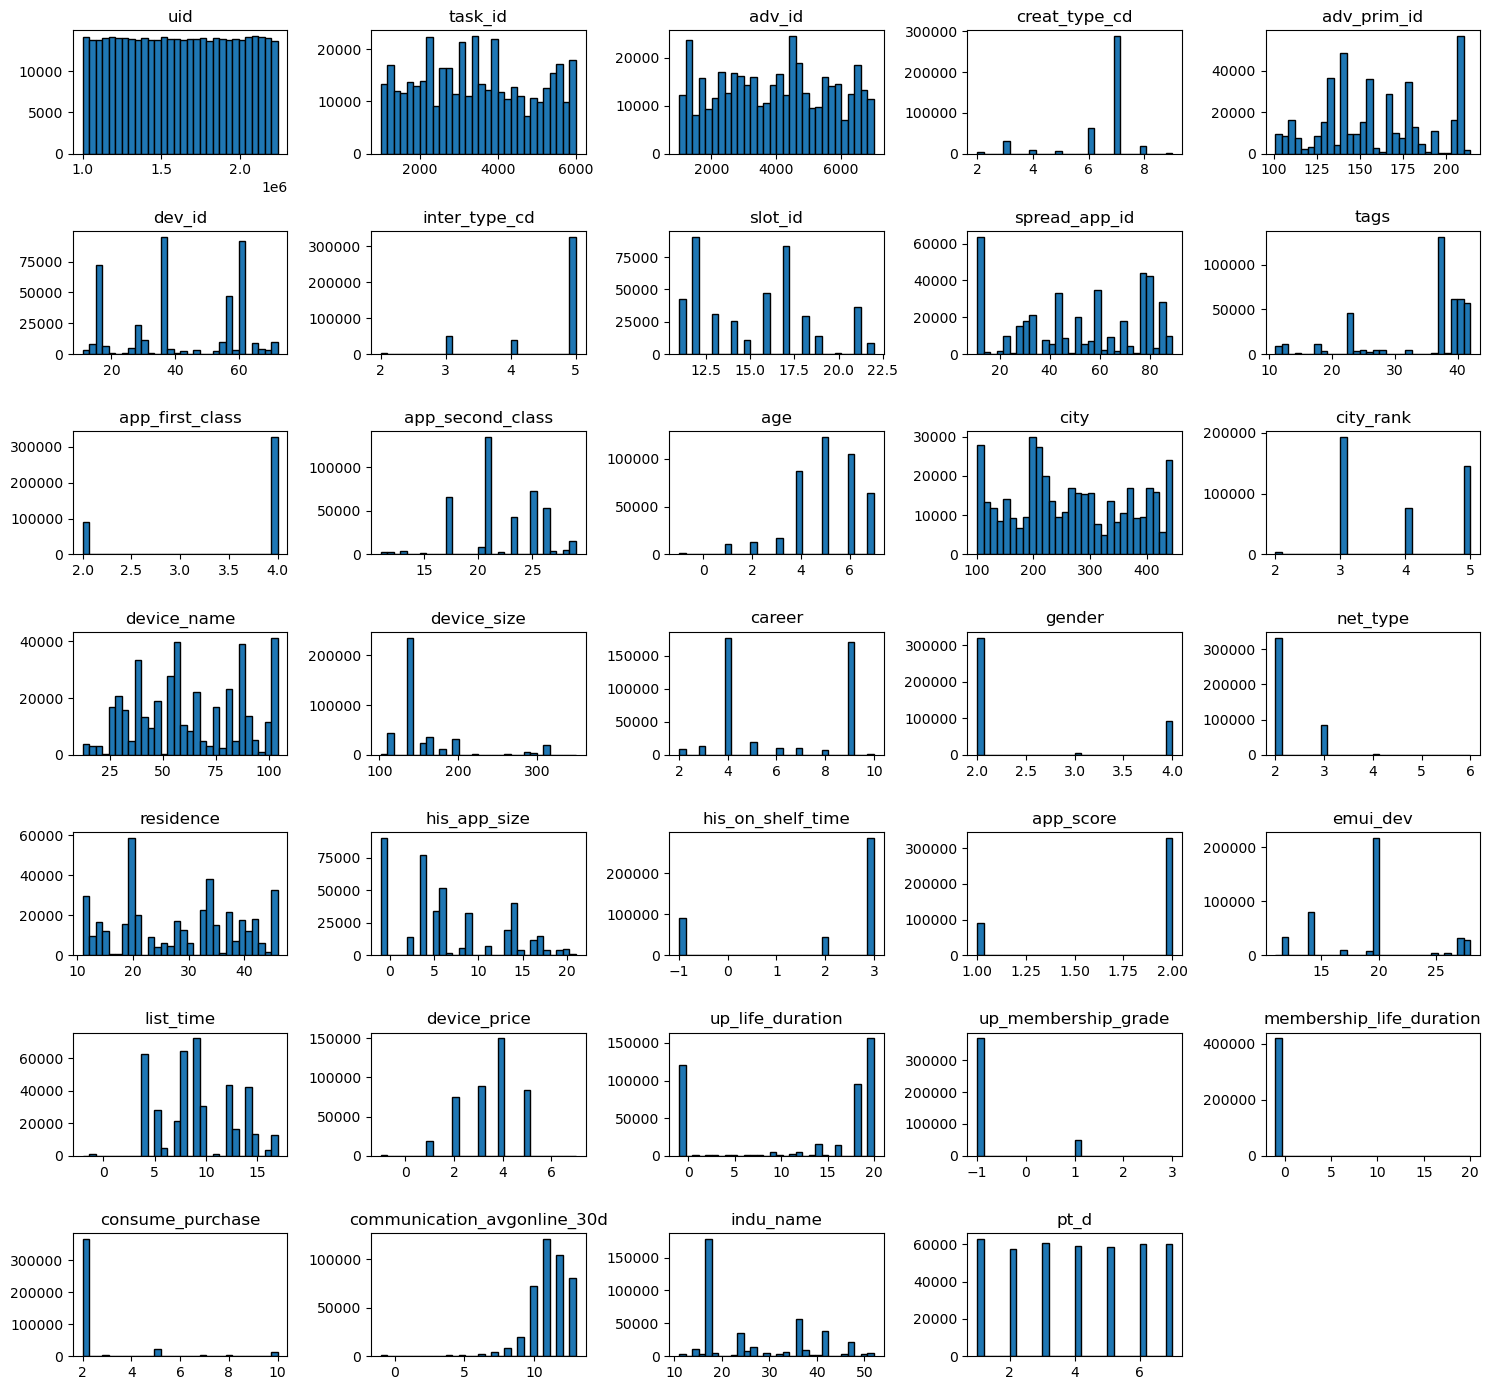

In [109]:
num_columns = len(columns_to_standardize)
rows = (num_columns + 4) // 5  
cols = 5

plt.figure(figsize=(15, 2 * rows))

for i, col in enumerate(columns_to_standardize, 1):
    plt.subplot(rows, cols, i) 
    plt.hist(df[col], bins=30, edgecolor='k')
    plt.title(col)
    plt.tight_layout()

plt.show()